In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask
import odc.geo.xr  # noqa
import xarray as xr
import xclim
from odc.geo import CRS

from ocr import catalog
from ocr.risks.fire import classify_wind_directions, direction_histogram, nws_fire_weather
from ocr.utils import load_conus404

In [3]:
# args = {
#     'name': 'fire-weather-distribution',
#     'region': 'us-west-2',
#     'n_workers': [2, 30],
#     'tags': {'Project': 'OCR'},
#     'worker_vm_types': 'm8g.2xlarge',
#     'scheduler_vm_types': 'm8g.2xlarge',
# }
# cluster = coiled.Cluster(**args)
# client = cluster.get_client()

In [4]:
# Make relative humidity intermediate data variable

In [5]:
%%time
ds = load_conus404()
ds

CPU times: user 1.34 s, sys: 396 ms, total: 1.74 s
Wall time: 11.7 s


<xarray.Dataset> Size: 13TB
Dimensions:   (time: 376945, y: 1015, x: 1367)
Coordinates:
  * x         (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * time      (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * y         (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs       int64 8B ...
    lat       (y, x) float32 6MB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon       (y, x) float32 6MB dask.array<chunksize=(10, 10), meta=np.ndarray>
Data variables:
    PSFC      (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    Q2        (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    T2        (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    TD2       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    U10       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    V10       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    SINALPHA  (y, x) float32 6MB dask.array<chunksize=(175, 175), meta=np.ndarray>
    COSALPHA  (y, x) float32 6MB dask.array<chunksize=(175, 175), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [6]:
%%time
recreate_rh = False
if recreate_rh:
    hurs = xclim.indicators.atmos.relative_humidity_from_dewpoint(tas=ds['T2'], tdps=ds['TD2'])
    hurs = dask.optimize(hurs)[0]
    hurs.to_zarr(
        's3://carbonplan-ocr/intermediate/met-data/conus404/hurs.zarr',
        consolidated=True,
        mode='w',
    )

else:
    hurs = xr.open_zarr('s3://carbonplan-ocr/intermediate/met-data/conus404/hurs.zarr')

CPU times: user 146 ms, sys: 40.5 ms, total: 186 ms
Wall time: 956 ms


In [7]:
# Make sfcWindspeed and sfcWindfromdir intermediate variables

In [8]:
%%time
recreate_winds = True
if recreate_winds:
    # rotate the grid-relative winds to earth-relative winds: https://forum.mmm.ucar.edu/threads/rotating-wrf-u-and-v-winds-before-and-after-reprojection.11788/
    # earth_u = u*cosa(ix,iy)-v*sina(ix,iy)
    # earth_v = v*cosa(ix,iy)+u*sina(ix,iy)
    with xr.set_options(keep_attrs=True):
        earth_u = ds.U10 * ds.COSALPHA - ds.V10 * ds.SINALPHA
        earth_v = ds.V10 * ds.COSALPHA + ds.U10 * ds.SINALPHA

    winds = xclim.indicators.atmos.wind_speed_from_vector(uas=earth_u, vas=earth_v)
    wind = xr.merge(winds)
    wind = dask.optimize(wind)[0]
    # winds.to_zarr(
    #     's3://carbonplan-ocr/intermediate/met-data/conus404/winds.zarr',
    #     consolidated=True,
    #     mode='w',
    # )

else:
    wind = xr.open_zarr('s3://carbonplan-ocr/intermediate/met-data/conus404/winds.zarr')

/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


CPU times: user 7.06 s, sys: 141 ms, total: 7.2 s
Wall time: 8.61 s


In [9]:
# calculate whether there is fire weather

In [10]:
fire_weather_mask = nws_fire_weather(
    hurs['hurs'],
    15,
    # reason that wind gusts are typically ~40% higher than average wind speed
    # and we want to base this on wind gusts (need a citation for this)
    wind['sfcWind'] * 1.4,
    35,
)

fire_weather_mask = dask.optimize(fire_weather_mask)[0]

In [11]:
%%time
recreate_direction_indices = True
if recreate_direction_indices:
    direction_indices = classify_wind_directions(wind['sfcWindfromdir'])
    # direction_indices.to_zarr(
    #     's3://carbonplan-ocr/intermediate/met-data/conus404/winds-direction-indices.zarr',
    #     consolidated=True,
    #     mode='w',
    # )

else:
    direction_indices = xr.open_zarr(
        's3://carbonplan-ocr/intermediate/met-data/conus404/winds-direction-indices.zarr'
    )['wind_direction_classification']

direction_indices

CPU times: user 1.85 ms, sys: 484 μs, total: 2.34 ms
Wall time: 2.03 ms


<xarray.DataArray 'wind_direction_classification' (time: 376945, y: 1015,
                                                   x: 1367)> Size: 2TB
dask.array<classify_block, shape=(376945, 1015, 1367), dtype=float32, chunksize=(376945, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * time     (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs      int64 8B 1
    lat      (y, x) float32 6MB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon      (y, x) float32 6MB dask.array<chunksize=(10, 10), meta=np.ndarray>
Attributes:
    long_name:         wind direction classified into 8 cardinal directions (...
    short_name:        wind_direction_classification
    direction_labels:  ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

In [12]:
%%time
recreate_fraction = True
if recreate_fraction:
    # we are going to reuse this. we should save it to a zarr store
    # then we can apply the fire_weather_mask dynamically.
    masked_direction_indices = direction_indices.where(fire_weather_mask)

    # create the distribution of winds based upon the classified wind directions
    # if there are nans in the mix, they won't contribute to the distribution
    fraction = direction_histogram(masked_direction_indices)
    fraction = dask.optimize(fraction)[0]

    # fraction.to_zarr(
    #     's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_distribution-hurs15_wind35.zarr',
    #     mode='w',
    #     consolidated=True,
    # )
else:
    fraction = xr.open_zarr(
        's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_distribution-hurs15_wind35.zarr'
    )['wind_direction_histogram']

fraction

CPU times: user 6.44 s, sys: 129 ms, total: 6.57 s
Wall time: 6.62 s


<xarray.DataArray 'wind_direction_histogram' (y: 1015, x: 1367,
                                              wind_direction: 8)> Size: 44MB
dask.array<transpose, shape=(1015, 1367, 8), dtype=float32, chunksize=(10, 10, 8), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs      int64 8B 1
    lat      (y, x) float32 6MB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon      (y, x) float32 6MB dask.array<chunksize=(10, 10), meta=np.ndarray>
Dimensions without coordinates: wind_direction
Attributes:
    long_name:  Wind Direction Histogram
    units:      probability

In [13]:
%%time
recreate_mode = False
if recreate_mode:
    # sum up the fractions of all of the wind directions. if any pixel sums to zero it will
    # fall into the no_fire_weather mask and be cast to a `nan`. if any pixel has any fraction
    # of timestamps with fire weather then it will be cast into the mask where there *is* fire weather
    no_fire_weather = fraction.sum(dim='wind_direction')
    mode = fraction.argmax(dim='wind_direction').where(no_fire_weather).chunk({'x': -1, 'y': -1})

    # mode.to_zarr(
    #     's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_mode-hurs15_wind35.zarr',
    #     mode='w',
    #     consolidated=True,
    # )

else:
    mode = xr.open_zarr(
        's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_mode-hurs15_wind35.zarr'
    )
mode

CPU times: user 19.8 ms, sys: 2.89 ms, total: 22.7 ms
Wall time: 345 ms


<xarray.Dataset> Size: 11MB
Dimensions:                   (y: 1015, x: 1367)
Coordinates:
  * y                         (y) float64 8kB -2.028e+06 ... 2.028e+06
  * x                         (x) float64 11kB -2.732e+06 ... 2.732e+06
Data variables:
    wind_direction_histogram  (y, x) float64 11MB dask.array<chunksize=(1015, 1367), meta=np.ndarray>

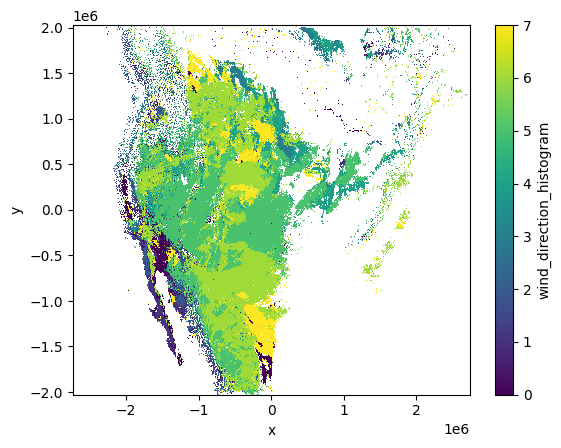

In [14]:
mode.wind_direction_histogram.plot(robust=True)

## Reproject mode to match USFS product

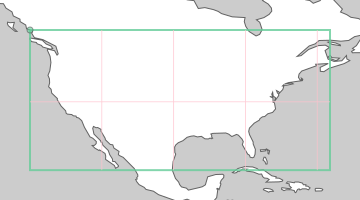

In [15]:
dataset = (
    catalog.get_dataset('USFS-wildfire-risk-communities-4326')
    .to_xarray()
    .astype('float32')[['CRPS']]
)
dataset = dataset.odc.assign_crs('epsg:4326')
dataset.odc.geobox

In [16]:
# Build CRS from the CF grid_mapping variable (spherical LCC)
src_crs = CRS(ds['crs'].attrs['crs_wkt'])
da = mode.odc.assign_crs(src_crs)
da

<xarray.Dataset> Size: 11MB
Dimensions:                   (y: 1015, x: 1367)
Coordinates:
  * y                         (y) float64 8kB -2.028e+06 ... 2.028e+06
  * x                         (x) float64 11kB -2.732e+06 ... 2.732e+06
    spatial_ref               int32 4B 0
Data variables:
    wind_direction_histogram  (y, x) float64 11MB dask.array<chunksize=(1015, 1367), meta=np.ndarray>

In [17]:
result = (
    da.odc.reproject(dataset.odc.geobox, resampling='nearest')
    .astype('int16')
    .chunk({'latitude': 6000, 'longitude': 4500})
)
result = dask.optimize(result)[0]
result

<xarray.Dataset> Size: 41GB
Dimensions:                   (latitude: 97579, longitude: 208881)
Coordinates:
  * latitude                  (latitude) float64 781kB 52.48 52.48 ... 22.43
  * longitude                 (longitude) float64 2MB -128.4 -128.4 ... -64.05
    spatial_ref               int32 4B 4326
Data variables:
    wind_direction_histogram  (latitude, longitude) int16 41GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>

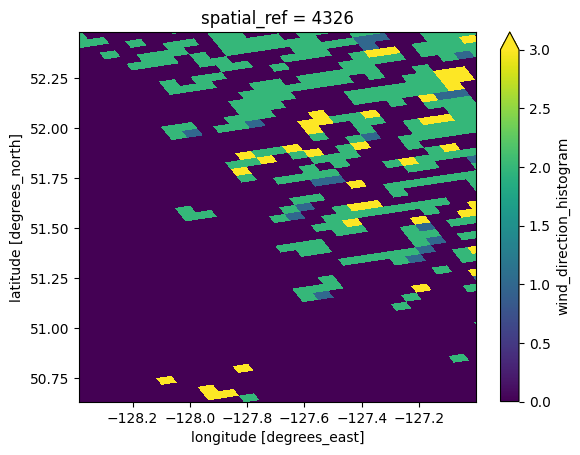

In [18]:
result.wind_direction_histogram.isel(latitude=slice(6000), longitude=slice(4500)).plot(robust=True);